# Function Approximation with a Multilayer Perceptron

This code is provided as supplementary material of the lecture Machine Learning and Optimization in Communications (MLOC).<br>

This code illustrates:
* training of neural networks by hand
* approximation of a function using a multilayer perceptron consisting of 3 hidden units with sigmoid activation function and a linear output unit
* stochastic gradient descent versus Adam

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
function_select = 5

def myfun(x):
    functions = {
        1: np.power(x,2), # quadratic function
        2: np.sin(x), # sinus
        3: np.sign(x), # signum
        4: np.exp(x), # exponential function
        5: np.abs(x)
    }
    return functions.get(function_select)



In [3]:
# Generate training data.
N = 32
x_train = np.linspace(-2, 2, num=N).reshape(-1,1)

# Generate the evaluation data. 
# (can exceed the range of the training data to evaluate the prediction capabilities)
x_eval = np.linspace(-2, 2, num=N).reshape(-1,1) 

Function definitions. Here we consider a hard-coded two-layer perception with one hidden layer, using the hyperbolic tangent as activation function, and a linear output layer. The output of the perceptron can hence be written as
\begin{equation*}
\hat{f}(x,\boldsymbol{\theta}) = \sum_{i=1}^3v_i\sigma(w_ix+b_i)
\end{equation*}
where $\sigma(x) = \tanh(x)$.
Instead of specifying all the parameters individually, we group them in a single vector $\boldsymbol{\theta}$ with
\begin{equation*}
\boldsymbol{\theta}=\begin{pmatrix}
v_1 & w_1 & b_1 & v_2 & w_2 & b_2 & v_3 & w_3 & b_3\end{pmatrix}
\end{equation*}

In [4]:
def sigma(x):
    return np.tanh(x)

# First order derivative of sigma (here tanh)
def sigma_prime(x):
    return 1-(np.tanh(x))**2

def MLP(x,theta):
    # hard-coded MLP, all parameters are inside theta
    y = theta[0]*sigma(theta[1]*x + theta[2]) + theta[3]*sigma(theta[4]*x+theta[5]) + theta[6]*sigma(theta[7]*x+theta[8])
    return y

The cost function is the mean-squared error, i.e.,
\begin{equation*}
J(\boldsymbol{\theta},\mathbb{X}^{[\text{train}]},\mathbb{Y}^{[\text{train}]}) = \frac{1}{N}\sum_{i=1}^N\left(\hat{f}(x_i^{[\text{train}]},\boldsymbol{\theta}) - y_i^{[\text{train}]}\right)^2
\end{equation*}
The gradient of the cost function can be computed by hand as
\begin{equation*}
\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta},\mathbb{X}^{[\text{train}]},\mathbb{Y}^{[\text{train}]}) = \frac{1}{N}\sum_{i=1}^N\left(\hat{f}(x_i^{[\text{train}]},\boldsymbol{\theta}) - y_i^{[\text{train}]}\right)\begin{pmatrix}
\sigma(\theta_2x_i^{[\text{train}]}+\theta_3) \\
\theta_1\sigma^\prime(\theta_2x_i^{[\text{train}]}+\theta_3)x_i^{[\text{train}]} \\
\theta_1\sigma^\prime(\theta_2x_i^{[\text{train}]}+\theta_3) \\
\sigma(\theta_5x_i^{[\text{train}]}+\theta_6) \\
\theta_4\sigma^\prime(\theta_5x_i^{[\text{train}]}+\theta_6)x_i^{[\text{train}]} \\
\theta_4\sigma^\prime(\theta_5x_i^{[\text{train}]}+\theta_6) \\
\sigma(\theta_8x_i^{[\text{train}]}+\theta_9) \\
\theta_7\sigma^\prime(\theta_8x_i^{[\text{train}]}+\theta_9)x_i^{[\text{train}]} \\
\theta_7\sigma^\prime(\theta_8x_i^{[\text{train}]}+\theta_9) \end{pmatrix}
\end{equation*}
where $\sigma^\prime(x) = \frac{\partial}{\partial x}\tanh(x) = 1 - \tanh^2(x)$

In [5]:
def cost_function(x, y, theta):
    # cost function is mean-squared error bvetween the training set x and the y
    difference = np.array([MLP(e, theta) for e in x]) - y
    return np.dot(difference.T, difference)/len(x)

# gradient of the cost function
def cost_function_gradient(x, y, theta):    
    gradient = np.zeros(9)
    for k in range(len(x)):        
        ig = np.zeros(9)
        ig[0] = sigma(theta[1]*x[k]+theta[2])
        ig[1] = theta[0]*sigma_prime(theta[1]*x[k]+theta[2])*x[k]
        ig[2] = theta[0]*sigma_prime(theta[1]*x[k]+theta[2])

        ig[3] = sigma(theta[4]*x[k]+theta[5])
        ig[4] = theta[3]*sigma_prime(theta[4]*x[k]+theta[5])*x[k]
        ig[5] = theta[3]*sigma_prime(theta[4]*x[k]+theta[5])

        ig[6] = sigma(theta[7]*x[k]+theta[8])
        ig[7] = theta[6]*sigma_prime(theta[7]*x[k]+theta[8])*x[k]
        ig[8] = theta[6]*sigma_prime(theta[7]*x[k]+theta[8])        
    
        gradient += 2*(MLP(x[k],theta) - y[k])*ig
    return gradient / len(x)

Here, we compare two different optimization functions. The first function is classical steepest gradient descent with a fixed step size. We evaluate the cost function in each step of the loop.

In [6]:
def approx_1d_function_gd(x_train, theta_initial, epochs): 
    # Generate labels for training data (here: the image of the selected function applied to X_train)
    y_train = myfun(x_train)
    
    # initialize weights to random data
    theta = theta_initial
    
    
    epsilon = 0.001
    cost_evolution = np.zeros(epochs)
    # carry out gradient descent
    for k in range(epochs):
        gradient = cost_function_gradient(x_train, y_train, theta)
        theta = theta - epsilon * gradient
        cost_evolution[k] = cost_function(x_train, y_train, theta)

    return theta, cost_evolution

The second optimizer is the Adam algorithm [1]. The Adam algorithm uses adaptive estimates of lower-order moments to improve the convergence of gradient descent. Due to its good performance, the Adam algorithm is very widely used in machine learning and in particular deep learning nowadays.

The Adam algorithm uses the following hyperparameters:
* The learning rate $\alpha$, which we set to $\alpha = 0.001$
* The decay rates $\beta_1$ and $\beta_2$, which we set to $\beta_1 = 0.9$ and $\beta_2 = 0.999$
* A small constant $\epsilon = 10^{-8}$

Starting with an initial random $\boldsymbol{\theta}_0$ and estimates of the first and second moment $\boldsymbol{m}_0=\boldsymbol{0}$ and $\boldsymbol{v}_0=\boldsymbol{0}$, the algorithm works as follows:

Set $t=0$.<br>
while not converged, do<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$t\leftarrow t+1$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\boldsymbol{g}_t \leftarrow \nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta},\mathbb{X}^{[\textrm{train}]},\mathbb{Y}^{[\textrm{train}]})$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\boldsymbol{m}_t \leftarrow \beta_1\cdot\boldsymbol{m}_{t-1}+(1-\beta_1)\cdot \boldsymbol{g}_{t}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\boldsymbol{v}_t \leftarrow \beta_2\cdot \boldsymbol{v}_{t-1}+(1-\beta_2)\cdot(\boldsymbol{g}_t\odot\boldsymbol{g}_t)$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\boldsymbol{p}_t\leftarrow \boldsymbol{m}_t/(1-\beta_1^t)$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\boldsymbol{q}_t \leftarrow \boldsymbol{v}_t/(1-\beta_2^t)$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\boldsymbol{\theta}_t \leftarrow \boldsymbol{\theta}_{t-1} - \alpha\cdot \boldsymbol{p}\oslash(\sqrt{\boldsymbol{q}}+\epsilon)$<br>
where $\oslash$ denotes element-wise division of two vectors. Furthermore, $\sqrt{\boldsymbol{q}}$ means element-wise application of the square-root to the elements of the vector $\boldsymbol{q}$.

Here, we implement and run the Adam algorithm.


[1] D. P. Kingma and J. L. Ba, "Adam: A Method for Stochastic Optimization," published at ICLR 2015, available at https://arxiv.org/pdf/1412.6980.pdf

In [7]:
def approx_1d_function_adam(x_train, theta_initial, epochs):
    y_train = myfun(x_train)

    theta = theta_initial
    beta1 = 0.9
    beta2 = 0.999
    alpha = 0.001
    epsilon = 1e-8

    cost_evolution = np.zeros(epochs)

    m = np.zeros(theta.shape)
    t = 0
    v = np.zeros(theta.shape)
    for k in range(epochs):
        t += 1
        g = cost_function_gradient(x_train, y_train, theta)
        m = beta1*m + (1-beta1)*g
        v = beta2*v + (1-beta2)*(g**2)
        mhat = m/(1-beta1**t)
        vhat = v/(1-beta2**t)
        theta = theta - alpha*mhat/(np.sqrt(vhat)+epsilon)
        cost_evolution[k] = cost_function(x_train, y_train, theta)        
    return theta, cost_evolution

Carry out the optimization using 50000 iterations with gradient descent and Adam.

In [8]:
epochs = 50000
np.random.seed(1)
theta_initial = np.random.randn(9)

theta_adam, cost_evolution_adam = approx_1d_function_adam(x_train, theta_initial, epochs)
theta_gd, cost_evolution_gd = approx_1d_function_gd(x_train, theta_initial, epochs)

# compute evaluation
predictions = MLP(x_eval, theta_adam)

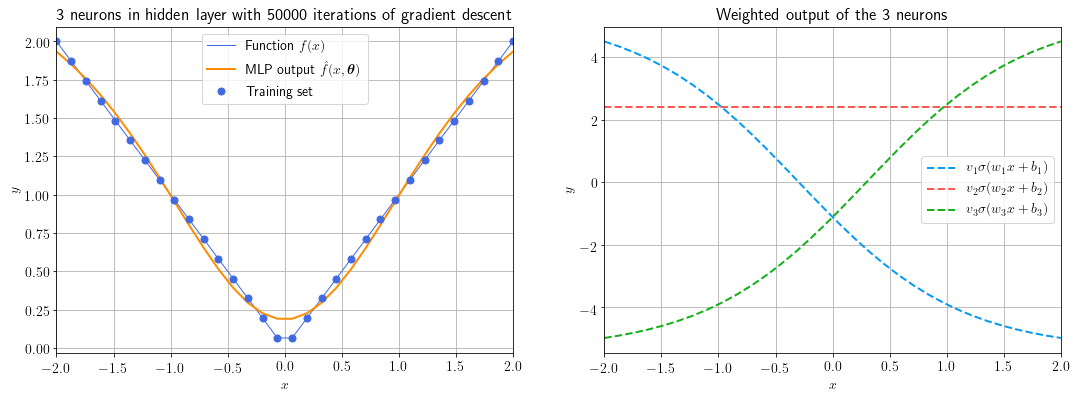

In [9]:
fig = plt.figure(1, figsize=(18,6))
font = {'size'   : 14}
plt.rc('font', **font)
plt.rc('text', usetex=matplotlib.checkdep_usetex(True))
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{amssymb}\usepackage{bm}')
ax = fig.add_subplot(1, 2, 1)
plt.plot(x_eval, myfun(x_eval), '-', color='royalblue', linewidth=1.0)
plt.plot(x_eval, predictions, '-', label='output', color='darkorange', linewidth=2.0)
plt.plot(x_train, myfun(x_train), '.', color='royalblue',markersize=14)
plt.xlim((min(x_train),max(x_train)))
plt.grid(which='both');
plt.rcParams.update({'font.size': 14})
plt.xlabel('$x$');
plt.ylabel('$y$')
plt.title('3 neurons in hidden layer with %d iterations of gradient descent' % epochs)
plt.legend(['Function $f(x)$', r'MLP output $\hat{f}(x,\bm{\theta})$', 'Training set'])

ax = fig.add_subplot(1, 2, 2)
plt.plot(x_eval, [theta_adam[0]*sigma(theta_adam[1]*x + theta_adam[2]) for x in x_eval], '--', label='output', color='xkcd:azure', linewidth=2.0)
plt.plot(x_eval, [theta_adam[3]*sigma(theta_adam[4]*x + theta_adam[5]) for x in x_eval], '--', label='output', color='xkcd:coral', linewidth=2.0)
plt.plot(x_eval, [theta_adam[6]*sigma(theta_adam[7]*x + theta_adam[8]) for x in x_eval], '--', label='output', color='xkcd:green', linewidth=2.0)
plt.grid(which='both');
plt.xlim((min(x_train),max(x_train)))
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Weighted output of the 3 neurons')
plt.legend(['$v_1\sigma(w_1x+b_1)$', '$v_2\sigma(w_2x+b_2)$', '$v_3\sigma(w_3x+b_3)$'])
#plt.savefig('3neuron_MLP_abs.pdf',bbox_inches='tight')
plt.show()    


Text(0, 0.5, 'Cost function $J(\\bm{\\theta},\\mathbb{X}^{[\\textrm{train}]},\\mathbb{Y}^{[\\textrm{train}]})$')

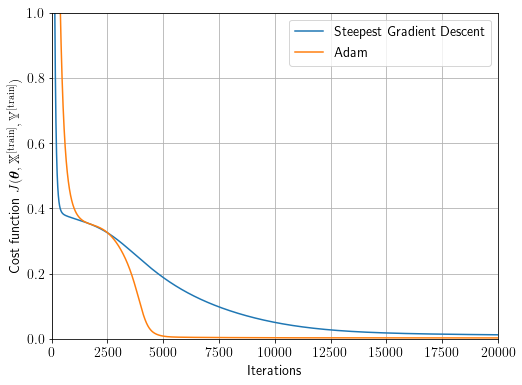

In [10]:
fig = plt.figure(2, figsize=(8,6))
plt.plot(range(epochs), cost_evolution_gd)
plt.plot(range(epochs), cost_evolution_adam)
plt.xlim((0,20000))
plt.ylim((0,1))
plt.grid(which='both')
plt.legend(['Steepest Gradient Descent', 'Adam'])
plt.xlabel('Iterations')
plt.ylabel(r'Cost function $J(\bm{\theta},\mathbb{X}^{[\textrm{train}]},\mathbb{Y}^{[\textrm{train}]})$')
#plt.savefig('3neuron_MLP_abs_cost.pdf',bbox_inches='tight')
